In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
#import Quantum_RR_2D as qrr
import schrodinger_2D as qrr
from datetime import datetime 
import scipy.fft as spfft
from joblib import Parallel, delayed
import multiprocessing
print(multiprocessing.cpu_count())
%matplotlib inline
num_cores = 20

20


In [2]:
#Constats in the units such that mass is in atomic mass unit (amu), 
#time is in micro seconds, distances are in micrometers. We call these notebook units
kB = 1.38064852e-23 #Boltzman's Constant
UK = (60e-6) #Trap depth in kelvin
U = kB*UK/(1.66e-27) #In energy units converted to notebook units
hb = 6.62607004e-34*1e6/(2*np.pi*1.66e-27) #Plank's constant
wtrap = 2 #Gaussian trap wasit in micrometers
mK = 41 # mass of atom in amu
lm = 0.790 #wavelength of light forming the gaussian trap in micrometers
#rmax = 3 #maximum distance for lattice in radial direction
#Nr = 2000 # number of lattice points in radial direction
g = 9.806/1e6;#acceleration due to gravity in notebook units

0.24951479277108432

In [3]:
def Vfun(X, Y, params):
        """
        This function returns the potential energies for a gaussian beam in 3D.
        
        Inputs
        ------
        R: np.array
            np.array of the r axis
        Z: np.array
            np.array of the z axis
        params: list
            list of parameters for the potential energy function
        
        Returns
        -------
        V: np.array
            np.array of the potential energy of the 3D QSHO
        """
        Nx = len(X)
        Ny = len(Y)
        M = Nx * Ny
        V = np.zeros((Nx,Ny))
        vindex = 0
        w0 = params[1]
        l  = params[2]
        for i in range(Nx):
            for j in range(Ny):
                rsq = X[i]**2+Y[j]**2
                V[i,j] = -params[0]*np.exp(-2*rsq/(w0**2))-mK*g*Y[j]                              
        return V

In [4]:
#2D spatial grid to consider for the wavefunctions
samplerate = 1400 # Number of points along one direction
xlim = 40
ylim = 40
xarray = np.arange(-xlim,xlim,2*xlim/samplerate)
yarray = np.arange(-ylim,ylim,2*ylim/samplerate)
karaysq = qrr.get_k_array(xarray,yarray,samplerate)

xs, ys = np.meshgrid(xarray, yarray, sparse=True)

In [5]:
evals = np.load('Simulation_data/2D_evals_30uK.npy')
evts = np.load('Simulation_data/2D_evecs_30uK.npy')
xlist = np.load('Simulation_data/2D_xlist_30uK.npy')
ylist = np.load('Simulation_data/2D_ylist_30uK.npy')


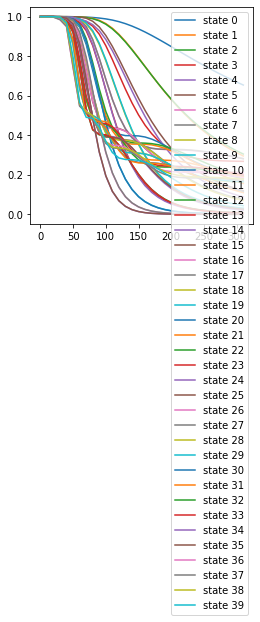

 Time elapsed (hh:mm:ss.ms) 2:28:25.346750


In [6]:
xtraprange = int((2*wtrap/xlim)*samplerate)
xm = int(samplerate/2)-xtraprange
xp = int(samplerate/2)+xtraprange
timevars = [0,320,10] #[t0,tf,dt]
timevars1 = [0,1100,2,500] #[t0,tf,dt]
params = [U,wtrap,lm]
prob_RR_all = []
start_time = datetime.now()
nevts = 40
def get_RR(i):
    psi = evts[i]
    psi_target1 = qrr.get_extrapolated_wfn(psi,xlist,ylist,xs,ys)
    #psifft =  spfft.ifftn(psi_target1,axes = [0,1])
    tarray,psit = qrr.schrodinger2D_kspace_TD(psi_target1,karaysq,timevars, hb, mK)
    prob_RR = []
    for j in range(tarray.shape[0]):
        psi0 = psit[j]
        tarray1,psit1 = qrr.Splitstep_2D_TD(xarray,yarray,psi0,timevars1,Vfun, params,karaysq, hb, mK)
        psi =psit1[-1]  
        prob_RR.append(np.sum(np.abs(psi[xm:xp,xm:xp])**2))
    return prob_RR     

tarray = np.arange(timevars[0], timevars[1], timevars[2])
prob_RR_all = Parallel(n_jobs=num_cores)(delayed(get_RR)(i) for i in range(nevts))
fig = plt.figure(figsize = (4,4))
prob_RR_all_pl = np.array(prob_RR_all)
for pl in range(nevts):
    plt.plot(tarray,prob_RR_all_pl[pl],label = 'state %i'%pl)
plt.legend()
plt.show()
prob_RR_all = np.array(prob_RR_all)


time_elapsed = datetime.now() - start_time 
print('\r','Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed)) 

In [7]:
np.save('Simulation_data/prob_RR_U30uK_40egs',prob_RR_all)
np.save('Simulation_data/tarray_U30uK',tarray)

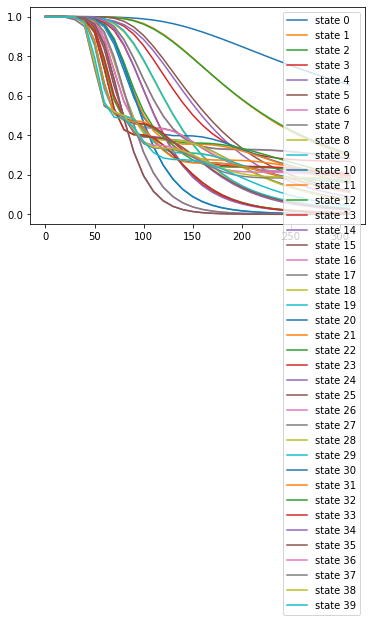

In [8]:
for j in range(nevts):
    prob_RR = prob_RR_all[j]
    plt.plot(tarray,prob_RR,label = 'state %i'%j)
plt.legend()
prob_RR_all = np.array(prob_RR_all)

In [9]:
prob_RR_all.shape

(40, 32)